In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation as animation
from scipy import integrate
from progressbar import progressbar as prbar        # (use pip/conda install progressbar2, or rewrite line 116.)
from copy import copy

In [32]:
RABBIT = 0
FOX = 1

UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3
STAY = 4

# initial number of rabbits and foxes
nrabbits = 1
nfoxes = 1

# size of the grid
gridxsize = 30
gridysize = 30

# energy of a freshly spawned rabbit/fox
rabben = 20
foxen = 20

# chance of a new fox/rabbit being spawned at a gridpoint on a step
rabbit_newborn_chance = 0.01
fox_newborn_chance = 0.005

# number of steps to simulate
steps = 1000

In [33]:
class Animal(object):
    """
    Tracks the animal's position, energy, species (rabbit/fox) and state (live/dead).
    """

    def __init__(self, x0, y0, init_energy, species):
        self.x = x0
        self.y = y0
        self.energy = init_energy
        self.species = species
        self.isDead = False


    def interact(self, other):
        """
        Interact with another animal:
            - If they're from the same species, ignore each other.
            - Fox eats rabbit.
        """
        if self.species == RABBIT and other.species == FOX:
            self.die()

        elif self.species == FOX and other.species == RABBIT:
            other.die()



    def die(self):
        "R.I.P"
        self.isDead = True


    def move(self, direction):
        """Move a step on the grid. Each step consumes 1 energy; if no energy left, die.
        If hitting the bounds of the grid, "bounde back", step to the opposite direction insetad.

        Arguments:
            direction {int} -- direction to move: UP: 0, DOWN: 1, LEFT: 2, RIGHT: 3, STAY: 4
        """
        self.energy -= 1

        if direction == LEFT:
            self.x += 1 if self.x > 0 else -1   #"bounce back"
        if direction == RIGHT:
            self.x -= 1 if self.x < gridxsize-1 else -1
        if direction == UP:
            self.y += 1 if self.y < gridysize-1 else -1
        if direction == DOWN:
            self.y -= 1 if self.y > 0 else -1
        if direction == STAY:
            pass

        if self.energy <= 0:
            self.die()          #R.I.P.



In [34]:
animals = []        # this will contain all animals on the grid


# all possible coordinate pair (following https://stackoverflow.com/a/11144716/5099168)
xcoords = np.arange(gridxsize)
ycoords = np.arange(gridysize)
coords = np.transpose([np.tile(xcoords, len(ycoords)), np.repeat(ycoords, len(xcoords))])

# populate grid randomly, unique coordinates for all animals
randcoords = np.random.permutation(coords)
rabbitcoords = randcoords[:nrabbits]
foxcoords = randcoords[nrabbits:(nrabbits + nfoxes)]

for (x, y) in rabbitcoords:
    animals.append(Animal(x0=x, y0=y, init_energy=rabben, species=RABBIT))
for (x, y) in foxcoords:
    animals.append(Animal(x0=x, y0=y, init_energy=foxen, species=FOX))


t_rabcoordsx = []   # track the coordinates of the animals in each step in these arrays
t_rabcoordsy = []
t_foxcoordsx = []
t_foxcoordsy = []

rabbitnums, foxnums = [nrabbits], [nfoxes]  #track the number of rabbits and foxes too

animfigs = []

In [35]:
for i in prbar(range(steps), max_value = steps, redirect_stdout=True):          # NOTE: substitute with for i in range(steps) if progressbar2 is not installed

    # step with each animal in a random direction
    directions = np.random.randint(0, 5, size=len(animals))
    for animal, direction in zip(animals, directions):
        animal.move(direction)

    # generate newborn rabbits...
    rabbit_is_born_here = np.random.rand(len(coords)) <= rabbit_newborn_chance
    newrabbits = coords[rabbit_is_born_here]
    for (x, y) in newrabbits:
        animals.append(Animal(x0=x, y0=y, init_energy=rabben, species=RABBIT))

    #...  and foxes
    fox_is_born_here = np.random.rand(len(coords)) <= fox_newborn_chance
    newfoxes = coords[fox_is_born_here]
    for (x, y) in newfoxes:
        animals.append(Animal(x0=x, y0=y, init_energy=foxen, species=FOX))

    # interact if two animals are at the same coordinates
    for j, animal1 in enumerate(animals):
        for animal2 in animals[j:]:
            if (animal1.x == animal2.x and
                animal1.y == animal2.y):
                animal1.interact(animal2)

    # clean up corpses
    dead_indexes = []
    for j, animal in enumerate(animals):
        if animal.isDead:
            dead_indexes.append(j)
    animals = list(np.delete(animals, dead_indexes))

    # count animals and log
    foxnum, rabnum = 0,0
    for animal in animals:
        if animal.species == RABBIT:
            rabnum += 1
        elif animal.species == FOX:
            foxnum += 1
    rabbitnums.append(rabnum)
    foxnums.append(foxnum)
    # print(rabnum, foxnum, len(dead_indexes))

    # get and log animal coordinates
    rabcsx = []
    rabcsy = []
    foxcsx = []
    foxcsy = []
    for animal in animals:
        if animal.species == RABBIT:
            rabcsx.append(animal.x)
            rabcsy.append(animal.y)
            # ax.plot(, animal.y, 'bo')
        elif animal.species == FOX:
            foxcsx.append(animal.x)
            foxcsy.append(animal.y)
            # ax.plot(animal.x, animal.y, 'ro')

    t_rabcoordsx.append(rabcsx)
    t_rabcoordsy.append(rabcsy)
    t_foxcoordsx.append(foxcsx)
    t_foxcoordsy.append(foxcsy)

100% (1000 of 1000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02


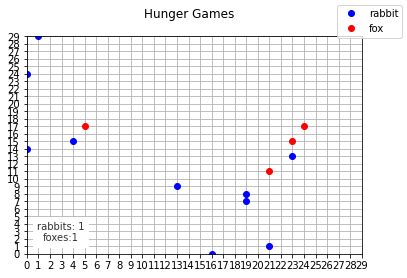

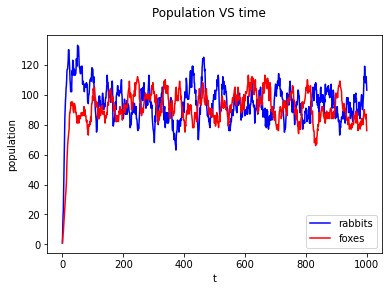

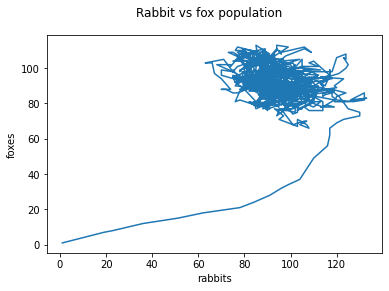

In [36]:
#Display the movement on an animation
fig, ax = plt.subplots()
fig.suptitle("Hunger Games")
ax.set_xlim(0, gridxsize-1)
ax.set_ylim(0, gridysize-1)
ax.set_xticks(xcoords)
ax.set_yticks(ycoords)
plt.grid(True)

rabpc, = ax.plot(t_rabcoordsx[0], t_rabcoordsy[0], 'bo', label='rabbit')
foxpc, = ax.plot(t_foxcoordsx[0], t_foxcoordsy[0], 'ro', label='fox')
fig.legend()

txt = ax.text(0.1, 0.1,'', ha='center', va='center', alpha=0.8,
              transform=ax.transAxes, fontdict={'color':'black', 'backgroundcolor': 'white', 'size': 10})

#initialize the animation:
def anim_init():
    rabpc.set_data(t_rabcoordsx[0], t_rabcoordsy[0])
    foxpc.set_data(t_foxcoordsx[0], t_foxcoordsy[0])
    txt.set_text('rabbits: {}\nfoxes:{}'.format(rabbitnums[0], foxnums[0]))
    return rabpc, foxpc, txt

#update the plot to the i-th frame:
def animate(i):
    rabpc.set_data(t_rabcoordsx[i], t_rabcoordsy[i])
    foxpc.set_data(t_foxcoordsx[i], t_foxcoordsy[i])
    txt.set_text('rabbits: {}\nfoxes:{}'.format(rabbitnums[i], foxnums[i]))
    return rabpc, foxpc, txt

#construct and display the animation
im_ani = animation.FuncAnimation(fig, animate, init_func=anim_init, frames=steps,
            interval=500, repeat=False, save_count=10, blit=True)
plt.show()


#plot population vs time
plt.plot(rabbitnums, 'b-', label="rabbits",)
plt.plot(foxnums, 'r-', label="foxes")
plt.xlabel('t')
plt.ylabel('population')
plt.suptitle("Population VS time")
plt.legend()
plt.show()

#plot rabbuts vs foxes
plt.suptitle("Rabbit vs fox population")
plt.plot(rabbitnums, foxnums)
plt.xlabel('rabbits')
plt.ylabel('foxes')
plt.show()